In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys, sagemaker, boto3
!{sys.executable} -m pip install -qU "sagemaker>=2.11.0"
print(sagemaker.__version__)

2.167.0


In [7]:
%%writefile src/inference_pytorch.py

import io, os, sys
import json
import subprocess, time

import numpy as np
from base64 import b64decode
from PIL import Image

import torch
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models.detection import FasterRCNN
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_fn(model_dir=None):
    '''
    Loads the model into memory from storage and return the model.
    '''
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # load the model onto the computation device
    model = model.eval().to(device)    
    return model

def transform_fn(model, request_body, content_type='application/x-image', accept_type=None):
    '''
    Deserialize the request body and predicts on the deserialized object with the model from model_fn()
    '''
    if content_type == 'application/x-image':             
        img = np.array(Image.open(io.BytesIO(request_body)))
    elif content_type == 'application/x-npy':    
        img = np.frombuffer(request_body, dtype='uint8').reshape(137, 236)   
    else:
        raise ValueError(
            'Requested unsupported ContentType in content_type : ' + content_type)

    t0 = time.time()
    
    test_transforms = transforms.Compose([
        transforms.ToTensor()
    ])
    img_tensor = test_transforms(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    with torch.no_grad():    
        result = model(img_tensor)

    t1 = time.time() - t0
    print("--- Elapsed time: %s secs ---" % t1)
    
    scores = result[0]['scores'].detach().cpu().numpy()
    bboxes = result[0]['boxes'].detach().cpu().numpy()
    cids = result[0]['labels'].detach().cpu().numpy()     
    
    outputs = json.dumps({'score': scores.tolist(), 
                       'bbox': bboxes.tolist(),
                         'cid': cids.tolist()})
    
    return outputs

Overwriting src/inference_pytorch.py


In [8]:
%%writefile src/utils.py

def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    
    for line in labels:
        line = line.rstrip("\n")
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] 
        
    return label_map


def get_label_map_imagenet(label_file):
    label_map = {}
    with open(label_file, 'r') as f:
        for line in f:
            key, val = line.strip().split(':')
            label_map[key] = val.replace(',', '')
    return label_map


def delete_endpoint(client, endpoint_name):
    response = client.describe_endpoint_config(EndpointConfigName=endpoint_name)
    model_name = response['ProductionVariants'][0]['ModelName']

    client.delete_model(ModelName=model_name)    
    client.delete_endpoint(EndpointName=endpoint_name)
    client.delete_endpoint_config(EndpointConfigName=endpoint_name)    
    
    print(f'--- Deleted model: {model_name}')
    print(f'--- Deleted endpoint: {endpoint_name}')
    print(f'--- Deleted endpoint_config: {endpoint_name}')    
    
    
def plot_bbox(img_resized, bboxes, scores, cids, class_info, framework='pytorch', threshold=0.5):

    import numpy as np
    import random
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    
    if framework=='mxnet':
        img_np = img_resized.asnumpy()
        scores = scores.asnumpy()
        bboxes = bboxes.asnumpy()
        cids = cids.asnumpy()
    else:
        img_np = img_resized
        scores = np.array(scores)
        bboxes = np.array(bboxes)
        cids = np.array(cids)    

    # Get only results that are above the threshold. Default threshold is 0.5. 
    scores = scores[scores > threshold]
    num_detections = len(scores)
    bboxes = bboxes[:num_detections, :]
    cids = cids[:num_detections].astype('int').squeeze()

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    random.seed(42)
    random.shuffle(colors)
    
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img_np)

    if cids is not None:
        # Get unique class labels 
        unique_labels = set(list(cids.astype('int').squeeze()))
        unique_labels = np.array(list(unique_labels))
        n_cls_preds = len(unique_labels)
        bbox_colors = colors[:n_cls_preds]

        for b, cls_pred, cls_conf in zip(bboxes, cids, scores):
            x1, y1, x2, y2 = b[0], b[1], b[2], b[3]
            predicted_class = class_info[int(cls_pred)]
            label = '{} {:.2f}'.format(predicted_class, cls_conf)
            
            # Get box height and width
            box_h = y2 - y1
            box_w = x2 - x1

            # Add a box with the color for this class
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)

            plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})

Overwriting src/utils.py


In [9]:
import os
import json
import numpy as np
from io import BytesIO
from PIL import Image
from src.inference_pytorch import model_fn, transform_fn
from src.utils import get_label_map, delete_endpoint, plot_bbox

label_map = get_label_map('files/coco_labels.txt')
label_list = list(label_map.values())
print(label_map)

path = "./images/test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

test_idx = 2
img_path = img_path_list[test_idx]

with open(img_path, mode='rb') as file:
    img_byte = bytearray(file.read())

img = Image.open(img_path)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [11]:
model = model_fn()
response_body = transform_fn(model, img_byte)
outputs = json.loads(response_body)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 67.3MB/s] 


--- Elapsed time: 10.886673212051392 secs ---


Matplotlib is building the font cache; this may take a moment.


<Figure size 640x480 with 0 Axes>

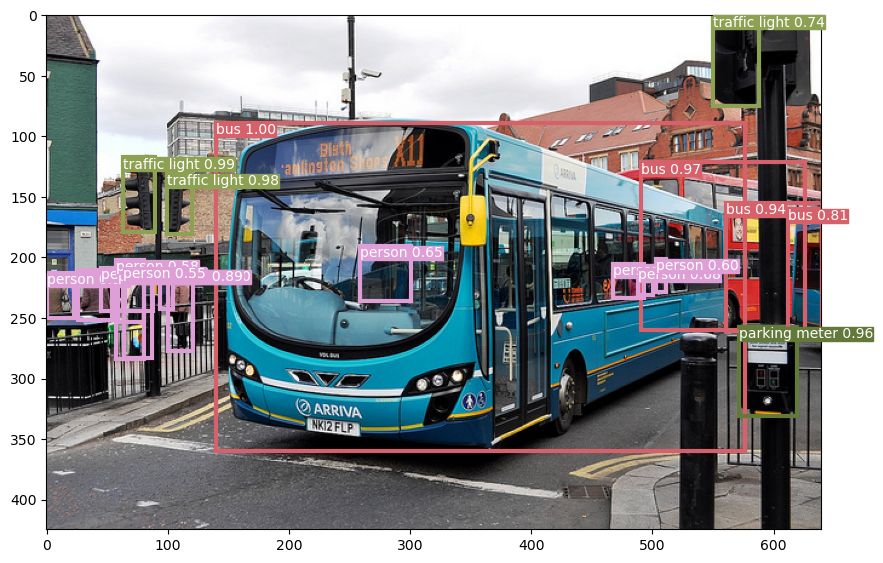

In [8]:
img = Image.open(img_path)
plot_bbox(img, outputs['bbox'], outputs['score'], outputs['cid'], class_info=label_map)

In [19]:
f = open("model.pth", 'w')
f.close()
!tar -czf model.tar.gz model.pth

In [20]:
import os
import time
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer
from sagemaker.pytorch.model import PyTorchModel
role = sagemaker.get_execution_role()

In [21]:
endpoint_name = "local-endpoint-pytorch-asc-sg-hands-on".format(int(time.time()))
local_model_path = f'file://{os.getcwd()}/model.tar.gz'
print(local_model_path)
import torch
print(torch.__version__)

file:///home/ec2-user/SageMaker/tfs-workshop/model.tar.gz
2.0.0


In [24]:
model = PyTorchModel(model_data=local_model_path,
                     role=role,
                     entry_point='inference_pytorch.py', 
                     source_dir='src',
                     framework_version='1.6.0',
                     py_version='py3')

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='local',
    serializer=IdentitySerializer(content_type='application/x-image'),
    deserializer=JSONDeserializer()
)

Attaching to ebmmfjxem6-algo-1-z5vnj
ebmmfjxem6-algo-1-z5vnj  | ['torchserve', '--start', '--model-store', '/.sagemaker/ts/models', '--ts-config', '/etc/sagemaker-ts.properties', '--log-config', '/opt/conda/lib/python3.6/site-packages/sagemaker_pytorch_serving_container/etc/log4j.properties', '--models', 'model.mar']
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:46,806 [INFO ] main org.pytorch.serve.ModelServer - 
ebmmfjxem6-algo-1-z5vnj  | Torchserve version: 0.3.1
ebmmfjxem6-algo-1-z5vnj  | TS Home: /opt/conda/lib/python3.6/site-packages
ebmmfjxem6-algo-1-z5vnj  | Current directory: /
ebmmfjxem6-algo-1-z5vnj  | Temp directory: /home/model-server/tmp
ebmmfjxem6-algo-1-z5vnj  | Number of GPUs: 0
ebmmfjxem6-algo-1-z5vnj  | Number of CPUs: 2
ebmmfjxem6-algo-1-z5vnj  | Max heap size: 964 M
ebmmfjxem6-algo-1-z5vnj  | Python executable: /opt/conda/bin/python3.6
ebmmfjxem6-algo-1-z5vnj  | Config file: /etc/sagemaker-ts.properties
ebmmfjxem6-algo-1-z5vnj  | Inference address: http://0.0.0.0:808

ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,699 [WARN ] W-9001-model_1-stderr org.pytorch.serve.wlm.WorkerLifeCycle -  19%|█▉        | 30.7M/160M [00:00<00:02, 58.3MB/s]
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,713 [WARN ] W-9000-model_1-stderr org.pytorch.serve.wlm.WorkerLifeCycle -  19%|█▉        | 30.1M/160M [00:00<00:01, 81.9MB/s]
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,732 [INFO ] pool-1-thread-3 ACCESS_LOG - /172.18.0.1:36744 "GET /ping HTTP/1.1" 200 71
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,756 [INFO ] pool-1-thread-3 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:7c8ba8a431ac,timestamp:null
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,830 [WARN ] W-9001-model_1-stderr org.pytorch.serve.wlm.WorkerLifeCycle -  24%|██▍       | 38.1M/160M [00:00<00:02, 60.1MB/s]
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:21:51,847 [WARN ] W-9000-model_1-stderr org.pytorch.serve.wlm.WorkerLifeCycle -  24%|██▎       | 37.9M/160M [00:00<00:01, 79.2MB/s]
ebmmfjxem6-algo-

In [25]:
!docker ps

CONTAINER ID   IMAGE                                                                               COMMAND                  CREATED          STATUS          PORTS                                                 NAMES
7c8ba8a431ac   763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/pytorch-inference:1.6.0-cpu-py3   "python /usr/local/b…"   56 seconds ago   Up 53 seconds   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   ebmmfjxem6-algo-1-z5vnj


In [26]:
outputs = predictor.predict(img_byte)

ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,298 [INFO ] pool-2-thread-1 TS_METRICS - CPUUtilization.Percent:100.0|#Level:Host|#hostname:7c8ba8a431ac,timestamp:1692530568
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,299 [INFO ] pool-2-thread-1 TS_METRICS - DiskAvailable.Gigabytes:41.03382110595703|#Level:Host|#hostname:7c8ba8a431ac,timestamp:1692530568
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,299 [INFO ] pool-2-thread-1 TS_METRICS - DiskUsage.Gigabytes:138.95444107055664|#Level:Host|#hostname:7c8ba8a431ac,timestamp:1692530568
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,300 [INFO ] pool-2-thread-1 TS_METRICS - DiskUtilization.Percent:77.2|#Level:Host|#hostname:7c8ba8a431ac,timestamp:1692530568
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,300 [INFO ] pool-2-thread-1 TS_METRICS - MemoryAvailable.Megabytes:1063.65625|#Level:Host|#hostname:7c8ba8a431ac,timestamp:1692530568
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:22:48,301 [INFO ] pool-2-thread-1 TS_METRICS - MemoryUsed.Megab

Matplotlib is building the font cache; this may take a moment.


<Figure size 640x480 with 0 Axes>

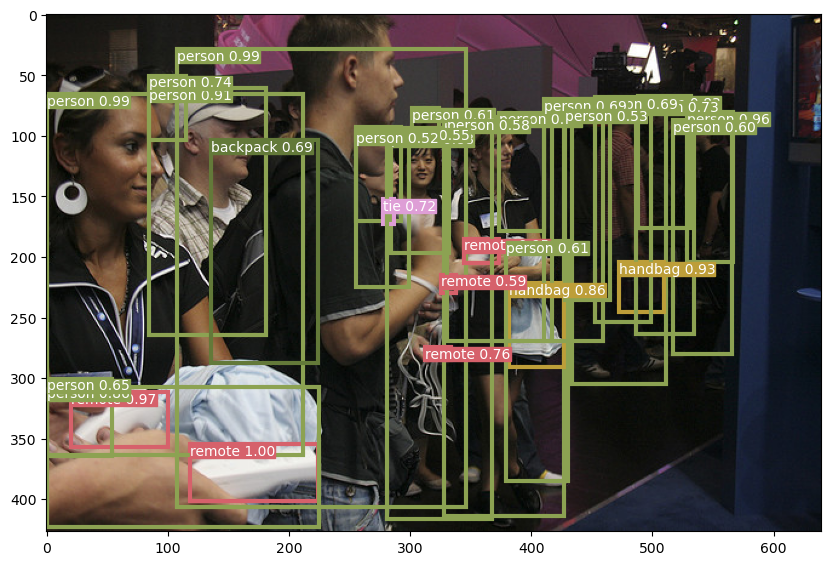

In [27]:
plot_bbox(img, outputs['bbox'], outputs['score'], outputs['cid'], class_info=label_map)

In [28]:
runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()
endpoint_name = model.endpoint_name

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-image',
    Accept='application/json',
    Body=img_byte
    )
outputs = json.loads(response['Body'].read().decode())

ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,085 [INFO ] W-9000-model_1-stdout org.pytorch.serve.wlm.WorkerLifeCycle - --- Elapsed time: 9.115719318389893 secs ---
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,085 [INFO ] W-9000-model_1 org.pytorch.serve.wlm.WorkerThread - Backend response time: 9144
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,085 [INFO ] W-9000-model_1-stdout MODEL_METRICS - PredictionTime.Milliseconds:9142.63|#ModelName:model,Level:Model|#hostname:7c8ba8a431ac,requestID:ca10c110-fae7-4a29-82c3-fe07c42712b5,timestamp:1692530602
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,086 [INFO ] W-9000-model_1 ACCESS_LOG - /172.18.0.1:57096 "POST /invocations HTTP/1.1" 200 9148
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,087 [INFO ] W-9000-model_1 TS_METRICS - Requests2XX.Count:1|#Level:Host|#hostname:7c8ba8a431ac,timestamp:null
ebmmfjxem6-algo-1-z5vnj  | 2023-08-20 11:23:22,087 [INFO ] W-9000-model_1 TS_METRICS - QueueTime.ms:0|#Level:Host|#hostname:7c8ba8a431ac,times

<Figure size 640x480 with 0 Axes>

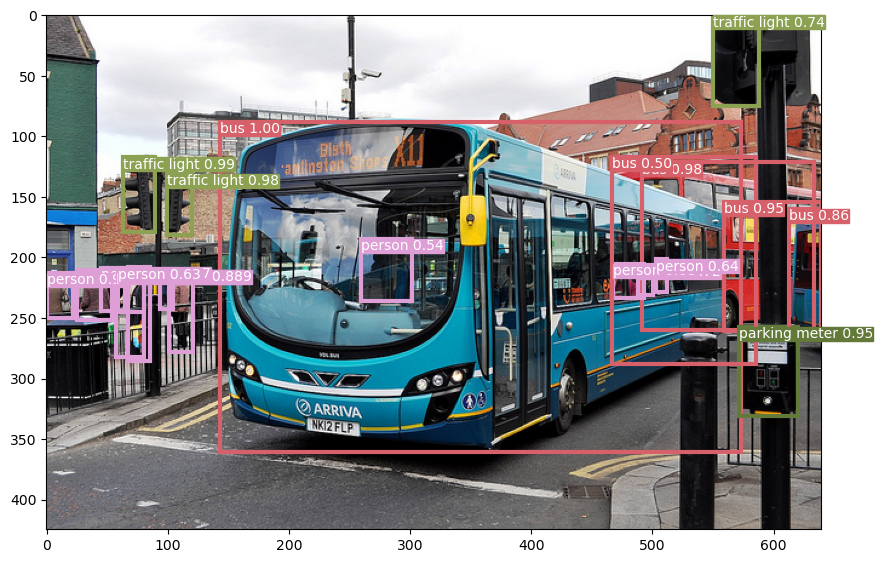

u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,822 [INFO ] pool-2-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:9dda19ef17e1,timestamp:1692450282
u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,824 [INFO ] pool-2-thread-1 TS_METRICS - DiskAvailable.Gigabytes:40.877471923828125|#Level:Host|#hostname:9dda19ef17e1,timestamp:1692450282
u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,824 [INFO ] pool-2-thread-1 TS_METRICS - DiskUsage.Gigabytes:139.11079025268555|#Level:Host|#hostname:9dda19ef17e1,timestamp:1692450282
u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,825 [INFO ] pool-2-thread-1 TS_METRICS - DiskUtilization.Percent:77.3|#Level:Host|#hostname:9dda19ef17e1,timestamp:1692450282
u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,828 [INFO ] pool-2-thread-1 TS_METRICS - MemoryAvailable.Megabytes:1243.7578125|#Level:Host|#hostname:9dda19ef17e1,timestamp:1692450282
u5bhxtpdpf-algo-1-l6gt6  | 2023-08-19 13:04:42,829 [INFO ] pool-2-thread-1 TS_METRICS - MemoryUsed.Mega

In [31]:
plot_bbox(img, outputs['bbox'], outputs['score'], outputs['cid'], class_info=label_map)

In [29]:
predictor.delete_endpoint()

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 862, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 928, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 130

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py", line 867, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpw8xn2533/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process

In [30]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [31]:
role = sagemaker.get_execution_role()
#bucket = '[YOUR-S3-BUCKET]' # bucket 이름을 반드시 수정해 주세요.
bucket = 'asc-sg-bucket' # SageMaker에서 자동으로 생성되는 bucket

In [32]:
%%bash -s "$role" "$bucket"
ROLE=$1
BUCKET=$2

aws s3 cp model.tar.gz s3://$BUCKET/model.tar.gz

upload: ./model.tar.gz to s3://asc-sg-bucket/model.tar.gz         


In [33]:
%%time

model_path = 's3://{}/model.tar.gz'.format(bucket)
endpoint_name = "endpoint-pytorch-object-detection-{}".format(int(time.time()))

model = PyTorchModel(model_data=model_path,
                     role=role,
                     entry_point='inference_pytorch.py', 
                     source_dir='src',
                     framework_version='1.6.0',
                     py_version='py3')

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    serializer=IdentitySerializer(content_type='application/x-image'),
    deserializer=JSONDeserializer()
)

-----!CPU times: user 566 ms, sys: 55.8 ms, total: 622 ms
Wall time: 3min 2s


In [34]:
predictor.endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'pytorch-inference-2023-08-20-11-29-05-148'

In [35]:
outputs = predictor.predict(img_byte)

<Figure size 640x480 with 0 Axes>

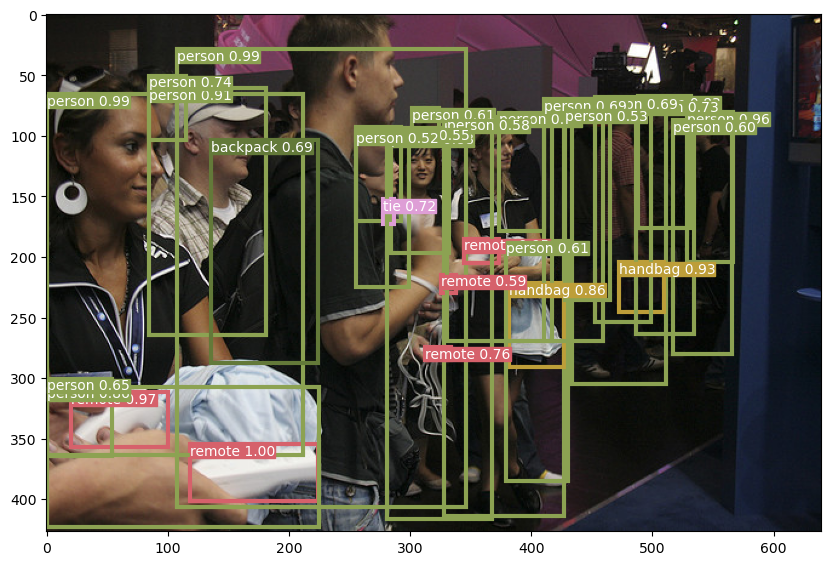

In [36]:
plot_bbox(img, outputs['bbox'], outputs['score'], outputs['cid'], class_info=label_map)

In [56]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [37]:
predictor.delete_endpoint()